In [1]:
import os
from argparse import ArgumentParser
from collections import OrderedDict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torchvision.utils as vutils
from torchvision.datasets import MNIST
from apex import amp
import pytorch_lightning as pl
from matplotlib import pyplot as plt


In [2]:
class MNISTDataModule(pl.LightningDataModule):

    def __init__(self, data_dir: str = './', batch_size: int = 64, num_workers: int = 8):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(64),
            transforms.CenterCrop(64),
            transforms.Normalize((0.5,), (0.5,))
        ])

        # self.dims is returned when you call dm.size()
        # Setting default dims here because we know them.
        # Could optionally be assigned dynamically in dm.setup()
        self.dims = (1, 64, 64)
        self.num_classes = 10

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == 'test' or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers,pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers,pin_memory=True)

In [47]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super().__init__()
        self.img_shape = img_shape
        def _block(in_channels, out_channels, kernel_size, stride, padding):
            return nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels,
                    out_channels,
                    kernel_size,
                    stride,
                    padding,
                    bias=False,
                ),
                #nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            )
        self.model = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            *_block(latent_dim, img_shape[1] * 16, 4, 1, 0),  # img: 4x4
            *_block(img_shape[1] * 16, img_shape[1] * 8, 4, 2, 1),  # img: 8x8
            *_block(img_shape[1] * 8, img_shape[1] * 4, 4, 2, 1),  # img: 16x16
            *_block(img_shape[1] * 4, img_shape[1] * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                img_shape[1] * 2, 1, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )
        
        
    def forward(self, z):
        img = self.model(z)
        return img
    
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super().__init__()
        
        def _block( in_channels, out_channels, kernel_size, stride, padding):
                    return nn.Sequential(
                        nn.Conv2d(
                            in_channels,
                            out_channels,
                            kernel_size,
                            stride,
                            padding,
                            bias=False,
                        ),
            #nn.BatchNorm2d(out_channels),
                        nn.LeakyReLU(0.2),
                    )
        self.model = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                1, img_shape[1], kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            *_block(img_shape[1], img_shape[1] * 2, 4, 2, 1),
            *_block(img_shape[1] * 2, img_shape[1] * 4, 4, 2, 1),
            *_block(img_shape[1] * 4, img_shape[1] * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(img_shape[1] * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

            
    def forward(self, img):
        out=self.model(img).view(-1,1)
        return out
    




In [48]:
 class GAN(pl.LightningModule):

    def __init__(
        self,
        channels,
        width,
        height,
        latent_dim: int = 100,
        lr: float = 0.0002,
        b1: float = 0.5,
        b2: float = 0.999,
        batch_size: int = 64,
        **kwargs
    ):
        super().__init__()
        self.save_hyperparameters()

        # networks
        data_shape = (channels, width, height)
        self.generator = Generator(latent_dim=self.hparams.latent_dim, img_shape=data_shape )
        self.discriminator = Discriminator(img_shape=data_shape)

        self.validation_z = torch.randn(8, self.hparams.latent_dim,1, 1)

        self.example_input_array = torch.zeros(2, self.hparams.latent_dim,1, 1)
        
        


  
    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
        
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        imgs, _ = batch

        # sample noise
        z = torch.randn(imgs.shape[0], 100,1, 1)
        z = z.type_as(imgs)

        # train generator
        if optimizer_idx == 0:

            # generate images
            self.generated_imgs = self(z)

            # log sampled images
            sample_imgs = self.generated_imgs[:6]
            grid = torchvision.utils.make_grid(sample_imgs,padding=2, normalize=True)
            self.logger.experiment.add_image('generated_images', grid, 0)

            # ground truth result (ie: all fake)
            # put on GPU because we created this tensor inside training_loop
            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs)

            # adversarial loss is binary cross-entropy
            g_loss = self.adversarial_loss(self.discriminator(self(z)), valid)
            tqdm_dict = {'g_loss': g_loss}
            output = OrderedDict({
                'loss': g_loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return output

        # train discriminator
        if optimizer_idx == 1:
            # Measure discriminator's ability to classify real from generated samples

            # how well can it label as real?
            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs)

            real_loss = self.adversarial_loss(self.discriminator(imgs), valid)

            # how well can it label as fake?
            fake = torch.zeros(imgs.size(0), 1)
            fake = fake.type_as(imgs)

            fake_loss = self.adversarial_loss(
                self.discriminator(self(z).detach()), fake)

            # discriminator loss is the average of these
            d_loss = (real_loss + fake_loss) / 2
            tqdm_dict = {'d_loss': d_loss}
            output = OrderedDict({
                'loss': d_loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return output
    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []
    
    def on_epoch_end(self):
        z = self.validation_z.type_as(self.generator.model[0].weight)
        # log sampled images
        sample_imgs = self(z)
        grid = torchvision.utils.make_grid(sample_imgs,padding=2, normalize=True)
        self.logger.experiment.add_image('generated_images', grid, self.current_epoch)
   

In [49]:

dm = MNISTDataModule()
dm.size()

(1, 64, 64)

In [50]:
model = GAN(*dm.size())


In [51]:
N, in_channels, H, W = 8, 1, 64, 64
noise_dim = 100
x = torch.randn((N, in_channels, H, W))
disc = model.discriminator(x)
print("disc: "+str(disc.size()))
z = torch.randn((N, noise_dim, 1, 1))
gen=model(z).squeeze(1)
print(str(gen.size()))


disc: torch.Size([8, 1])
torch.Size([8, 64, 64])


In [52]:
xx=gen.data.cpu().numpy()
print(xx[0])

[[-0.04487576 -0.04491818 -0.04542276 ... -0.04500624 -0.04426787
  -0.04478742]
 [-0.04440572 -0.04498895 -0.04451625 ... -0.04636611 -0.04582009
  -0.04501364]
 [-0.04479123 -0.04379487 -0.0447627  ... -0.04471378 -0.04497753
  -0.04498502]
 ...
 [-0.04447773 -0.04483259 -0.04543046 ... -0.04509919 -0.04592228
  -0.04475389]
 [-0.04464152 -0.04331294 -0.04480826 ... -0.04437978 -0.04461484
  -0.04455894]
 [-0.04481976 -0.04479377 -0.04525686 ... -0.04484737 -0.04469049
  -0.04472628]]


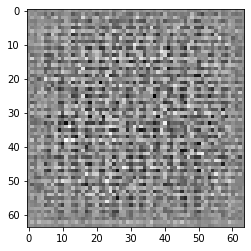

In [53]:
plt.imshow(xx[0],cmap='gray')
plt.show()

In [ ]:
trainer = pl.Trainer(gpus=1, max_epochs=2)
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | In sizes       | Out sizes     
----------------------------------------------------------------------------------
0 | generator     | Generator     | 12.7 M | [2, 100, 1, 1] | [2, 1, 64, 64]
1 | discriminator | Discriminator | 2.8 M  | ?              | ?             


In [ ]:
# Start tensorboard.
#%load_ext tensorboard
#%tensorboard --logdir lightning_logs/   --host localhost 


In [ ]:
z = torch.randn((N, noise_dim, 1, 1))
gen=model(z).squeeze(1)
xx=gen.data.cpu().numpy()
plt.imshow(xx[0],cmap='gray')
plt.show()